# Transpilation default settings and configuration options

<details>
<summary><b>Package versions</b></summary>

The code on this page was developed using the following requirements.
We recommend using these versions or newer.

```
qiskit[all]~=1.4.0
qiskit-ibm-runtime~=0.36.1
```
</details>

Abstract circuits need to be transpiled because QPUs have a limited set of basis gates and cannot execute arbitrary operations. The transpiler's function is to change arbitrary circuits so that they can run on a specified QPU.  This is done by translating the circuits to the supported basis gates, and by introducing SWAP gates as needed, so that the circuit's connectivity matches that of the QPU.

As explained in [Transpile with pass managers](transpile-with-pass-managers), you can create a [pass manager](/api/qiskit/qiskit.transpiler.PassManager) using the [`generate_preset_pass_manager`](/api/qiskit/qiskit.transpiler.generate_preset_pass_manager#qiskit.transpiler.generate_preset_pass_manager) function and pass a circuit or list of circuits to its [run](/api/qiskit/qiskit.transpiler.PassManager#run) method to transpile them. You can call `generate_preset_pass_manager` passing only the optimization level and backend, choosing to use the defaults for all other options, or you can pass additional arguments to the function to fine-tune the transpilation.

## Basic usage without parameters

In this example, we pass a circuit and target QPU to the transpiler without specifying any further parameters.

Create a circuit and view the result:

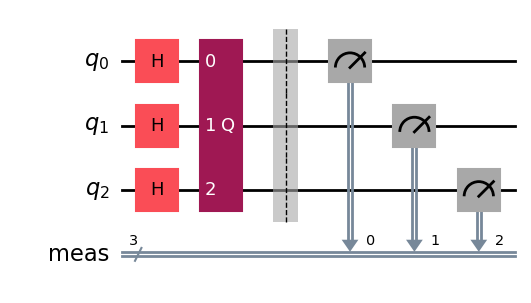

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import grover_operator, DiagonalGate
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

# Create circuit to test transpiler on
oracle = DiagonalGate([1] * 7 + [-1])
qc = QuantumCircuit(3)
qc.h([0, 1, 2])
qc = qc.compose(grover_operator(oracle))

# Add measurements to the circuit
qc.measure_all()

# View the circuit
qc.draw(output="mpl")

Transpile the circuit and view the result:

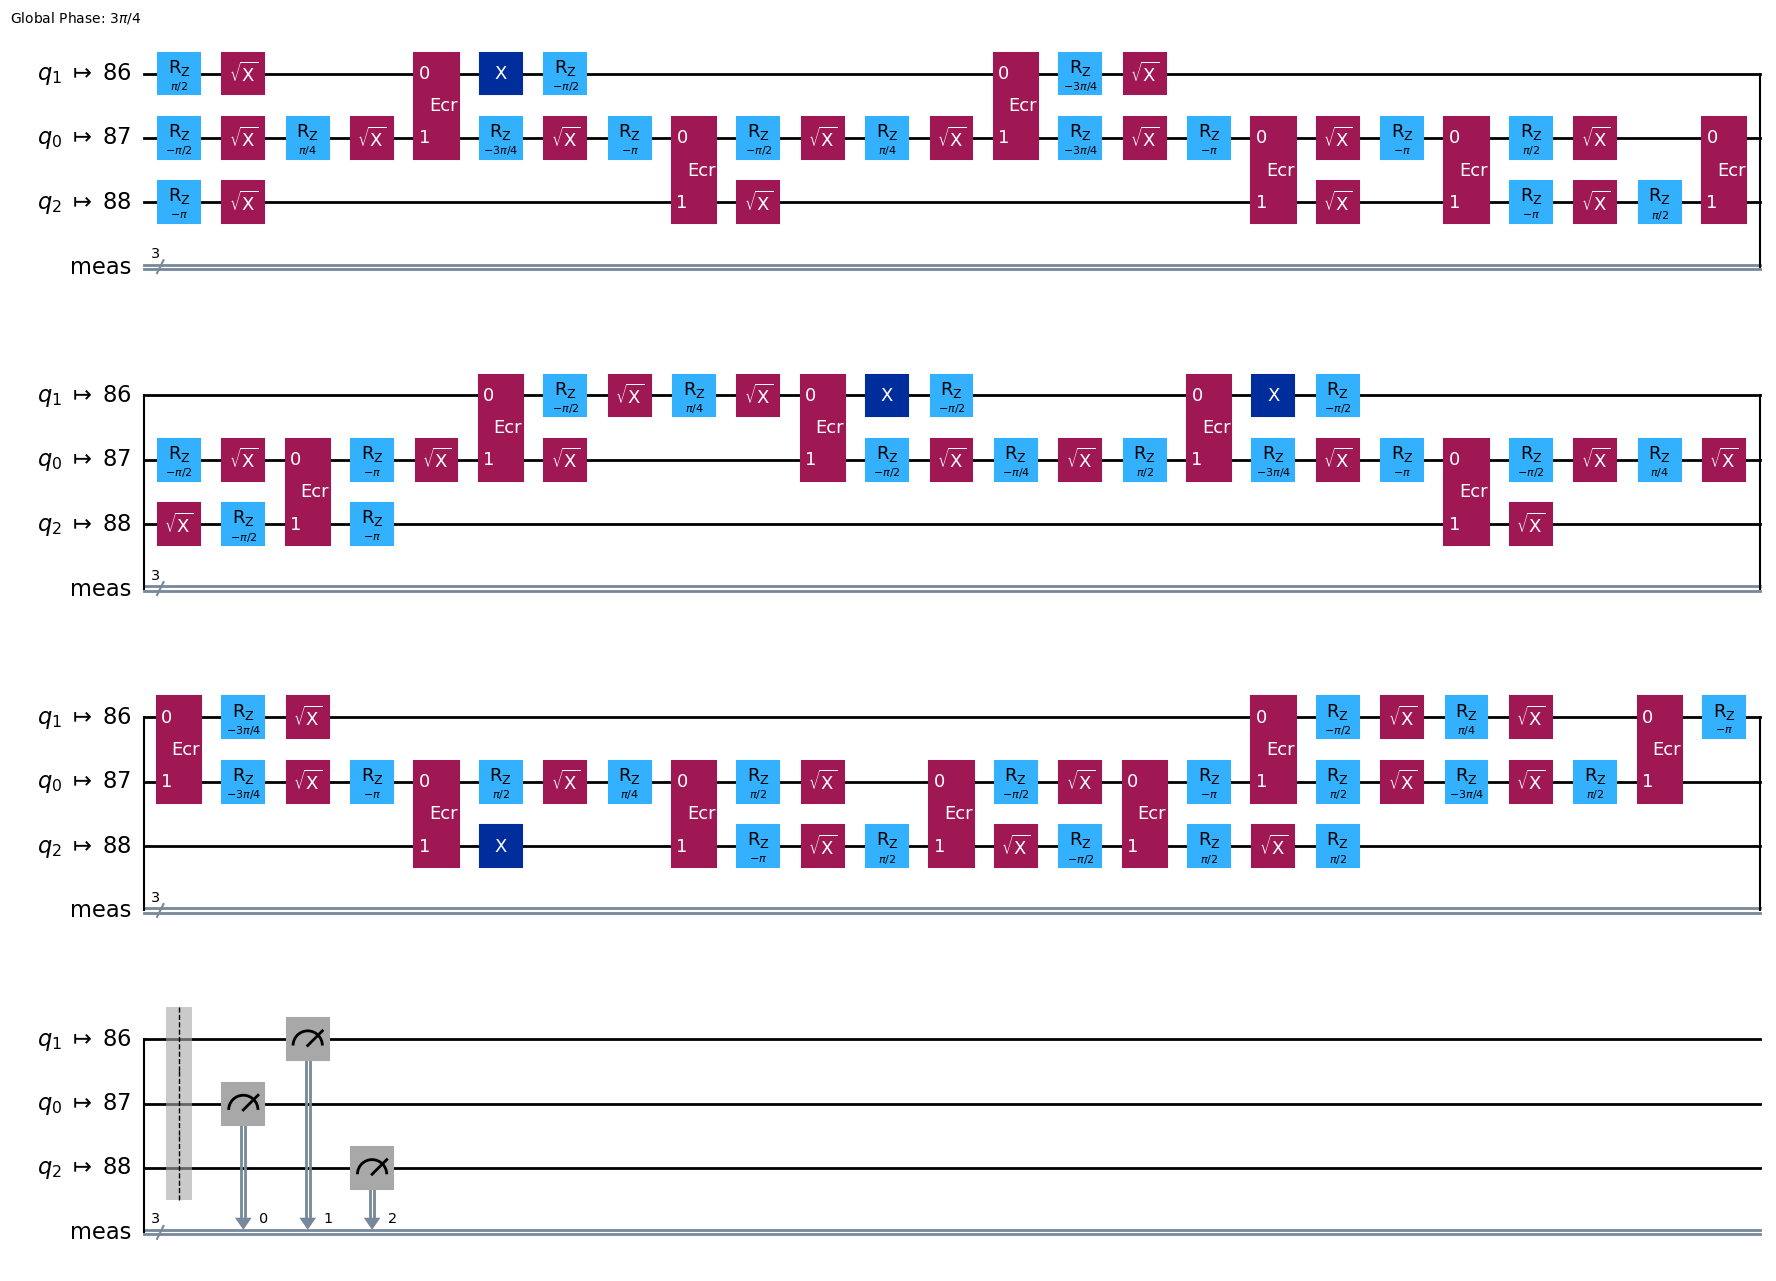

In [3]:
from qiskit.transpiler import generate_preset_pass_manager

# Specify the QPU to target
backend = FakeSherbrooke()

# Transpile the circuit
pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend
)
transpiled_circ = pass_manager.run(qc)

# View the transpiled circuit
transpiled_circ.draw(output="mpl", idle_wires=False)

## All available parameters

Following are all of the available parameters for the [`generate_preset_pass_manager`](/api/qiskit/qiskit.transpiler.generate_preset_pass_manager#qiskit.transpiler.generate_preset_pass_manager) function.  There are two classes of arguments: those that describe the target of compilation, and those that influence how the transpiler works.


All parameters except `optimization_level` are optional.  For full details, see the [Transpiler API documentation](/api/qiskit/transpiler#transpiler-api).

- `optimization_level` (int) - How much optimization to perform on the circuits. Integer in the range (0 - 3). Higher levels generate more optimized circuits, at the expense of longer transpilation time. See [Set transpiler optimization level](set-optimization) for more details.

### Parameters used to describe the compilation target:

These arguments describe the target QPU for circuit execution, including information such as the coupling map of the QPU (which describes the connectivity of the qubits), the basis gates supported by the QPU, and the error rates of the gates.

Many of these parameters are described in detail in [Commonly used parameters for transpilation](common-parameters).

<details>
  <summary>
    **QPU (`Backend`) parameters**
  </summary>

**Backend parameters** - If you specify `backend`, you don't need to specify `target` or any other backend options. Likewise, if you specify `target`, you don't need to specify `backend` or any other backend options.
- `backend` (Backend) - If this is set, the transpiler compiles the input circuit to this device. If any other option is set that impacts these settings, such as `coupling_map`, it overrides the settings from `backend`.
- `target` (Target) - A backend transpiler target. Normally this is specified as part of the backend argument, but if you manually constructed a Target object, you can specify it here. This overrides the target from `backend`.
- `backend_properties` (BackendProperties) - Properties returned by a QPU, including information on gate errors, readout errors, qubit coherence times, and so on. Find a QPU that provides this information by running `backend.properties()`.
- `timing_constraints` (Dict[str, int] | None) - An optional control hardware restriction on instruction time resolution. This information is provided by the QPU configuration. If the QPU doesn’t have any restriction on the instruction time allocation, `timing_constraints` is `None` and no adjustment is performed. A QPU might report a set of restrictions, namely:
    - `granularity`: An integer value representing the minimum pulse gate resolution in units of dt. A user-defined pulse gate should have a duration that is a multiple of this granularity value.
    - `min_length`: An integer value representing the minimum pulse gate length in units of dt. A user-defined pulse gate should be longer than this length.
    - `pulse_alignment`: An integer value representing a time resolution of gate instruction starting time. Gate instructions should start at a time that is a multiple of this value.
    - `acquire_alignment`: An integer value representing a time resolution of measure instruction starting time. Measure instruction should start at a time that is a multiple of this value.
</details>

<details>
  <summary>
    **Layout and topology parameters**
  </summary>

- `basis_gates` (List[str] | None) - List of basis gate names to unroll to.  For example ['u1', 'u2', 'u3', 'cx']. If `None`, do not unroll.
- `coupling_map` (CouplingMap | List[List[int]]) - Directed coupling map (possibly custom) to target in mapping. If the coupling map is symmetric, both directions need to be specified. These formats are supported:
    - CouplingMap instance
    - List - must be given as an adjacency matrix, where each entry specifies all directed two-qubit interactions supported by the QPU.  For example: [[0, 1], [0, 3], [1, 2], [1, 5], [2, 5], [4, 1], [5, 3]]
- `inst_map` (List[InstructionScheduleMap] | None) - Mapping of circuit operations to pulse schedules. If `None`, the QPU's `instruction_schedule_map` is used.
</details>


### Parameters used to influence how the transpiler works

These parameters impact specific transpilation stages. Some of them might impact multiple stages, but have only been listed under one stage for simplicity. If you specify an argument, such as `initial_layout`  for the qubits you want to use, that value overrides all the passes that could change it. In other words, the transpiler won't change anything that you manually specify. For details about specific stages, see [Transpiler stages](transpiler-stages).

<details>
  <summary>
    **Initialization stage**
  </summary>

- `hls_config` (HLSConfig) - An optional configuration class `HLSConfig` that is passed directly to the `HighLevelSynthesis` transformation pass. This configuration class lets you specify the lists of synthesis algorithms and their parameters for various high-level objects.
- `init_method` (str) - The plugin name to use for the initialization stage. By default, an external plugin is not used. You can see a list of installed plugins by running `list_stage_plugins()` with `init` for the stage name argument.
- `unitary_synthesis_method` (str) - The name of the unitary synthesis method to use. By default, `default` is used. You can see a list of installed plugins by running `unitary_synthesis_plugin_names()`.
- `unitary_synthesis_plugin_config` (dict) - An optional configuration dictionary that is passed directly to the unitary synthesis plugin. By default this setting has no effect because the default unitary synthesis method does not take custom configuration. Applying a custom configuration should only be necessary when a unitary synthesis plugin is specified with the `unitary_synthesis` argument. As this is custom for each unitary synthesis plugin, refer to the plugin's documentation for how to use this option.
</details>

<details>
  <summary>
    **Layout stage**
  </summary>

- `initial_layout` (Layout | Dict | List) - Initial position of virtual qubits on physical qubits. If this layout makes the circuit compatible with the `coupling_map` constraints, it will be used. The final layout is not guaranteed to be the same, as the transpiler might permute qubits through swaps or other means. For full details, see the [Initial layout section.](common-parameters#initial-layout)
- `layout_method` (str) - Name of layout selection pass (`default`, `dense`, `sabre` and `trivial`). This can also be the external plugin name to use for the layout stage. You can see a list of installed plugins by running `list_stage_plugins()` with `layout` for the `stage_name` argument. The default value is `sabre`.
</details>

<details>
  <summary>
    **Routing stage**
  </summary>

- `routing_method` (str) - Name of routing pass (`basic`, `lookahead`, `default`, `sabre`, or  `none`). This can also be the external plugin name to use for the routing stage. You can see a list of installed plugins by running `list_stage_plugins()` with `routing` for the `stage_name` argument. The default value is `sabre`.
</details>

<details>
  <summary>
    **Translation stage**
  </summary>

- `translation_method` (str) - Name of translation pass (`default`, `synthesis`, `translator`, `ibm_backend`, `ibm_dynamic_circuits`, `ibm_fractional`) This can also be the external plugin name to use for the translation stage. You can see a list of installed plugins by running `list_stage_plugins()` with `translation` for the `stage_name` argument. The default value is `translator`.
</details>

<details>
  <summary>
    **Optimization stage**
  </summary>

- `approximation_degree` (float, in the range 0-1 | None) - Heuristic dial used for circuit approximation (1.0 = no approximation, 0.0 = maximal approximation). The default value is 1.0.  Specifying `None` sets the approximation degree to the reported error rate. See the [Approximation degree section](common-parameters#approx-degree) for more details.
- `optimization_method` (str) - The plugin name to use for the optimization stage. By default an external plugin is not used. You can see a list of installed plugins by running `list_stage_plugins()` with `optimization` for the `stage_name` argument.
</details>

<details>
  <summary>
    **Scheduling stage**
  </summary>

- `scheduling_method` (str) - Name of the scheduling pass. This can also be the external plugin name to use for the scheduling stage. You can see a list of installed plugins by running `list_stage_plugins()` with `scheduling` for the `stage_name` argument.
  * 'as_soon_as_possible': Schedule instructions greedily, as early as possible on a qubit resource (alias: `asap`).
  * 'as_late_as_possible': Schedule instructions late, that is, keeping qubits in the ground state when possible (alias: `alap`).  This is the default.
</details>

<details>
  <summary>
    **Transpiler execution**
  </summary>

- `seed_transpiler` (int) - Sets random seeds for the stochastic parts of the transpiler.
</details>

The following default values are used if you don't specify any of the above parameters. Refer to the method's [API reference page](../api/qiskit/transpiler_preset) for more information:

In [5]:
generate_preset_pass_manager(
    optimization_level=1,
    backend=None,
    target=None,
    basis_gates=None,
    coupling_map=None,
    initial_layout=None,
    layout_method=None,
    routing_method=None,
    translation_method=None,
    scheduling_method=None,
    approximation_degree=1.0,
    seed_transpiler=None,
    unitary_synthesis_method="default",
    unitary_synthesis_plugin_config=None,
    hls_config=None,
    init_method=None,
    optimization_method=None,
)

## Next steps

<Admonition type="tip" title="Recommendations">
    - Learn how to [Set the optimization level](set-optimization).
    - Review more [Commonly used parameters](common-parameters).
    - Learn how to [Set the optimization level when using Qiskit Runtime.](./runtime-options-overview)
    - Visit the [Transpile with pass managers](transpile-with-pass-managers) topic.
    - For examples, see [Representing quantum computers.](./represent-quantum-computers)
    - Try the [Submit transpiled circuits](https://learning.quantum.ibm.com/tutorial/submit-transpiled-circuits) tutorial.
    - Learn [how to transpile circuits](https://learning.quantum.ibm.com/tutorial/submit-transpiled-circuits) as part of Qiskit Patterns workflows using Qiskit Runtime.
    - Review the [Transpile API documentation](/api/qiskit/transpiler).
</Admonition>